### Summary

This is my submission towards the QOSF September 2020 screening task. I have attempted task 1, which involves optimizing the parameters of a variational circuit so that its output comes as close as possible to a random quantum state. The effect of increasing the number of layers in the ansatz is to be shown via a plot.

### Author
Dhruv Bhatnagar

### Solution description
This solution:
* Uses a base class to simplify experimenting with different types of circuits
* Implements gradient descent for the optimization with a decay policy for the learning rate
* Compares different types of circuits in terms of simulating the target state

### Requirements

This notebook uses 

* Qiskit (version 0.19.6) for the quantum simulation
* numpy for array calculations
* pyplot from matplotlib for plotting
* Python's random module.


### Problem statement
The problem statement for task 1 (developed by QOSF) is given below:

#### Task 1 

Implement, on a quantum simulator of your choice, the following 4 qubits state $|\psi(\theta)>$:

![Circuit Ansatz](circuit_ansatz-1.jpg)

Where the number of layers, denoted with L, has to be considered as a parameter. We call ¨Layer¨ the combination of 1 yellow + 1 green block, so, for example, U1 + U2 is a layer. The odd/even variational blocks are given by:

Even block:

![Even block](even_block.jpg)

Odd block:

![Odd block](odd_block.jpg)

The angles $\theta_{i,n}$ are variational parameters, lying in the interval $(0, 2\pi)$, initialized at random. Double qubit gates are CZ gates.

Report with a plot, as a function of the number of layers, L, the minimum distance

$$= min_{\theta} ||\hspace{1mm}|\psi(\theta)> - |\phi>  ||$$

Where $|\phi>$ is a randomly generated vector on 4 qubits and the norm $||\hspace{1mm}|v> ||$, of a state $|v>$, simply denotes the square root of the sum of the modulus square of the components of $|v>$. The right set of parameters $\theta_{i,n}$ can be found via any method of choice (e.g. grid-search or gradient descent)

Bonus question:

Try using other gates for the parametrized gates and see what happens.

### Solution
First, we import the required packages.

In [6]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, Parameter
from qiskit import Aer, execute

import numpy as np
import random
from matplotlib import pyplot as plt

Next, we define a base class for the parametric circuits ansatze. This base class, "parametric_ckt", implements several useful methods like building the required quantum circuit for specified number of layers,  gradient descent algorithm for the optimization, cost function, and virtual methods for the odd and even layers. A plot generating function is also included.

A run method is provided to implement the optimization for multiple circuits up to the specified number of maximum layers. Once the circuit ansatz is defined, the run method will optimize the parametric circuits with different number of layers for the same randomly-generated quantum state (here, it is called the target state).

The idea behind developing this base class is to be able to focus on developing the odd and even layer circuits by extending this class as many times as desired. Therfore, in this notebook, this class will be extended several times with the desired odd- and even-layer circuits. Other methods, like the gradient descent, can be reused for circuits with different number of parameters! Besides this, this class is highly configurable, including the ability to generate target state and the circuit for the number of qubits not equal to 4 as well.


In [8]:
class parametric_ckt:
    """
    Base class for parametric or variational circuits used for this task. 
    
    Provides useful methods like initializing target quantum state randomly, 
    building circuit with specified odd and even layers, gradient descent to 
    optimize variational circuit to result in a state as close as possible
    to the target state.
    """
    
    def __init__(self, num_qubits):
        """Constructor for the class parametric_ckt. It initializes member variables to some possible default values."""
        
        self.num_qubits = num_qubits
        self.barriers_on = False
        self.alpha = 0.01
        self.max_iter = 1000
        self.theta_step = 0.01
        self.target_cost = 0.05
        self.max_layers = 7
        self.current_layers = 1
        self.qc = QuantumCircuit(num_qubits)
        self.name = 'Circuit'

    def init_ckt(self):
        """Creates a data member quantum circuit with number of qubits taken from class data member."""
        
        self.qc = QuantumCircuit(self.num_qubits)
    
    def init_target_state(self):
        """Initializes the target state variable randomly to a complex vector with unit norm."""
        
        random.seed(10598)
        self.target_state = np.zeros(2**self.num_qubits) + 1.0j*np.zeros(2**self.num_qubits)
        for i in range(2**self.num_qubits):
            self.target_state[i] = random.random() + 1.0j*random.random()
        self.target_state = self.target_state/np.linalg.norm(self.target_state)
        print("-----------------------------------------------------------------------")
        print("Initializing the target quantum state of ", self.num_qubits, " qubit(s) randomly as = \n", self.target_state[:,np.newaxis])
        print("Norm of the above vector is ", np.linalg.norm(self.target_state))

    def append_odd_layer(self, sub_layer_id):
        """Used to specify the quantum circuit for the odd layer. Useful for inherited classes."""
        
        #dummy identity gate implementation for this base class
        for i in range(self.num_qubits):
            self.qc.i(i)

    def append_even_layer(self, sub_layer_id):
        """Used to specify the quantum circuit for the even layer. Useful for inherited classes."""
        
        #dummy identity gate implementation for this base class
        for i in range(self.num_qubits):
            self.qc.i(i)
      
    def build_ckt(self, num_layers):
        """Builds the variational quantum circuit with odd and even layers as specified and given number of layers."""
        
        self.init_ckt()        
        for i in range(num_layers):
            self.append_odd_layer(2*i + 1)
            if(self.barriers_on):
                self.qc.barrier()
            self.append_even_layer(2*i + 2)
            if(self.barriers_on):
                self.qc.barrier()
        
        print("-----------------------------------------------------------------")        
        print("Circuit ", self.name, " constructed with ", num_layers, " layers. Number of parameters = ", len(self.qc.parameters), ".")
    
    def get_ckt(self):
        """Returns the quantum circuit member."""
        
        return self.qc
    
    def simulate_state(self, theta):
        """
        Returns the statevector after performing statevector simulation on 
        member quantum circuit with the given parameters.
        """
        
        d = {}
        for val in self.qc.parameters:
            d[val] = theta[val]
        local_qc = self.qc.copy('local_qc')
        #Deep copying the circuit as qiskit doesn't seem to support binding parameters repeatedly 
        #to the same parametric circuit
        local_qc = local_qc.bind_parameters(d)
        simulator_sv = Aer.get_backend('statevector_simulator')
        result_sv = execute(local_qc, simulator_sv).result()
        statevector_sv = result_sv.get_statevector(local_qc)
        return statevector_sv

    def get_cost(self, theta):
        """
        Returns the cost defined by 2-norm of difference between simulated state vector
        and target state vector.
        """
        
        statevector_sv = self.simulate_state(theta)
        return np.linalg.norm(statevector_sv - self.target_state)
    
    def grad_descent(self):
        """
        Implements gradiet descent algorithm to optimize the member quantum circuit
        to achieve the target state, and saves the optimal parameters.
        """
        
        #Initializing stuff related to the optimization
        iter_cnt = 0
        learning_rate = self.alpha
        reduced = 0
        self.theta_opt = {}
        random.seed(10598)
        
        #Initializing circuit parameters with random values
        params = {}
        for idx in self.qc.parameters:
            params[idx] = 0.05*random.random()
        print("-----------------------------------------------------------------")
        print("Initialized circuit parameters prior to gradient descent randomly as follows: ")
        for idx in self.qc.parameters:
            print("idx = ", idx, "params = ", params[idx])
        
        #calculate original cost(theta)
        f_orig = self.get_cost(params)

        #while((convergence_not_achieved) and (iter < max_iter))
        while((f_orig > self.target_cost) and (iter_cnt < self.max_iter)):
            #Empty dict to store gradient for this iteration
            grad = {}
        
            #for each parameter
            for idx in self.qc.parameters:
                #create grad_calc_param_dict initialized with original parameters for this iteration
                grad_calc_params = params.copy()

                #only 1 parameter replaced by theta_i + step, used to calculate partial derivative with 
                #respect to that parameter
                grad_calc_params[idx] += self.theta_step

                #calculate cost(theta_i + step, rest_theta_unchanged)
                f_new_theta_i = self.get_cost(grad_calc_params) 

                #calculate gradient wrt theta_i = (cost(theta_i + step, rest_theta) - cost(theta)) / theta_step
                #thereby obtaining the gradient wrt all parameters for this iteration
                grad[idx] = (f_new_theta_i - f_orig)/self.theta_step
        
            #for each parameter:
            for idx in self.qc.parameters:
                #update each parameter as follows: theta_i = theta_i - (learning_rate * gradient(theta_i))
                params[idx] -= learning_rate*grad[idx]

            #calculate cost(theta), where theta is updated theta after this iteration
            f_orig = self.get_cost(params)     

            iter_cnt += 1
        
            #This is a policy to reduce the learning rate based on current iteration
            #this reduces the learning rate as iterations increase, so that oscillation about minima due to
            #large learning rate gets avoided.
            #this has been figured out after several trials; more sophistcated strategies could be used.
            if(((iter_cnt % 40) == 0) and (iter_cnt < 140)):
                learning_rate /= np.sqrt(10)
                print("----------------------------------------------------------------------")
                print("REDUCING ALPHA TO ", learning_rate, " at iteration = ", iter_cnt)
        
            #Print covergence related information at the end of every iteration
            print("------------------------------------------------------------------------------------------------")
            print("Circuit = ", self.name, "| Layers = ", self.current_layers, " | At end of iteration = ", iter_cnt, " | cost = ", f_orig)
    
        #Print completion message 
        print("----------------------------------------------------------------------")
        print("Optimization complete.")

        #return optimum parameters
        self.theta_opt = params.copy()
        print("After optimization, the optimal parameters are \n", self.theta_opt, "\nThe output state for these parameters is \n", self.simulate_state(self.theta_opt)[:, np.newaxis])
    
    def run(self):
        """Optimizes parametric quantum circuits upto given maximum number of layers."""
        
        #Initializing the target quantum state once
        #same state will be used while optimizing circuits of different layers
        self.init_target_state()
        
        #Useful for plotting
        self.cost_arr = np.zeros((self.max_layers))
        self.layer_arr = np.linspace(1,self.max_layers,self.max_layers)
        
        #Building the circuit for differet layers and optimizing
        for i in range(1, self.max_layers+1):
            self.current_layers = i
            self.build_ckt(i)
        
            self.grad_descent()
        
            #Print cost after optimization is complete.
            print("----------------------------------------------------------------------")
            print("Circuit = ", self.name, " Layers = ", i, " Cost after optimization = ", self.get_cost(self.theta_opt))
            self.cost_arr[i-1] = self.get_cost(self.theta_opt)
        print("----------------------------------------------------------------------")
        print("After optimization for all specified layers, the respective minimum costs for ", self.name, " are: \n", self.cost_arr)
    
    def show_plot(self):
        """Used to plot variation of minimum cost/error after optimization vs number of layers."""
        
        plt.figure(figsize=(7,7))
        plt.plot(self.layer_arr, self.cost_arr, '--bo', label=self.name)
        plt.xlabel("Number of layers")
        plt.ylabel("Minimum cost after optimization of "+self.name)
        plt.title("Variation of minimum error vs number of layers for "+self.name)
        plt.legend()
        plt.show()
        

### Author's note on the gradient descent implementation

For the gradient descent implementation here, the initial learning rate (alpha) can be specified, but a policy based on the number of iterations to modify the learning rate has been implemented. As the number of iterations increase, the learning rate is decreased periodically. This was figured out because a fixed learning rate was either found to be too high and leading to an oscillation of the cost about the minima, or it was too low, thereby slowing down the optimization. A gradual decay is found to be a good approach to cover the initial reduction in the cost quickly, while reducing the learning rate later to be able to reach the minima carefully. 

While experimenting with different number of layers, I observed that perhaps the choice of initial learning rate (or decay thereof) which might be suitable to a particular number of layers (say, number of layers = 4) may not be suitable for a different number of layers (say, number of layers = 8). A possible reason for this could be that the "loss landscapes" for different number of layers vary significantly. The currently chosen combination of learning rate and step size for $\theta$ has been found by trying various combinations; more sophisticated strategies for learning rate decay can be explored.

### Using the developed class
As a sanity check, we will try to generate a quantum circuit of 4 qubits and 2 layers from this base class. The odd and even (sub)layers will both turn out to be the identity gates (as defined):

In [9]:
c0 = parametric_ckt(4)
c0.name = 'trial_ckt'
c0.barriers_on = True
c0.build_ckt(2)
qc0 = c0.get_ckt()
qc0.draw(output='text')

-----------------------------------------------------------------
Circuit  trial_ckt  constructed with  2  layers. Number of parameters =  0 .


┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ 
q_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─
     ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ 
q_1: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─
     ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ 
q_2: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─
     ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ 
q_3: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─
     └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░

Next, we extend the base class to implement the even and odd sub layers of the circuit ansatz given in the problem statement.

In [10]:
class problem_ckt(parametric_ckt):
    def append_odd_layer(self, sub_layer_id):
        theta = ParameterVector('theta'+str(sub_layer_id), length=self.num_qubits)
        for i in range(self.num_qubits):
            self.qc.rx(theta[i], i)

    def append_even_layer(self, sub_layer_id):
        theta = ParameterVector('theta'+str(sub_layer_id), length=self.num_qubits)
        for i in range(self.num_qubits):
            self.qc.rz(theta[i], i)
        for i in range(self.num_qubits):
            for j in range(i+1,self.num_qubits):
                self.qc.cz(i,j) 

To check this circuit, we will draw the 2 layer version below. The labelling convention for the parameters has been selected to be consistent with the figures in the problem statement.

In [11]:
c1 = problem_ckt(4)
c1.name = 'problem_ckt'
c1.barriers_on = True
c1.build_ckt(2)
qc1 = c1.get_ckt()
qc1.draw(output='text')

-----------------------------------------------------------------
Circuit  problem_ckt  constructed with  2  layers. Number of parameters =  16 .


┌───────────────┐ ░ ┌───────────────┐                   ░ »
q_0: ┤ RX(theta1[0]) ├─░─┤ RZ(theta2[0]) ├─■──■──■───────────░─»
     ├───────────────┤ ░ ├───────────────┤ │  │  │           ░ »
q_1: ┤ RX(theta1[1]) ├─░─┤ RZ(theta2[1]) ├─■──┼──┼──■──■─────░─»
     ├───────────────┤ ░ ├───────────────┤    │  │  │  │     ░ »
q_2: ┤ RX(theta1[2]) ├─░─┤ RZ(theta2[2]) ├────■──┼──■──┼──■──░─»
     ├───────────────┤ ░ ├───────────────┤       │     │  │  ░ »
q_3: ┤ RX(theta1[3]) ├─░─┤ RZ(theta2[3]) ├───────■─────■──■──░─»
     └───────────────┘ ░ └───────────────┘                   ░ »
«     ┌───────────────┐ ░ ┌───────────────┐                   ░ 
«q_0: ┤ RX(theta3[0]) ├─░─┤ RZ(theta4[0]) ├─■──■──■───────────░─
«     ├───────────────┤ ░ ├───────────────┤ │  │  │           ░ 
«q_1: ┤ RX(theta3[1]) ├─░─┤ RZ(theta4[1]) ├─■──┼──┼──■──■─────░─
«     ├───────────────┤ ░ ├───────────────┤    │  │  │  │     ░ 
«q_2: ┤ RX(theta3[2]) ├─░─┤ RZ(theta4[2]) ├────■──┼──■──┼──■──░─
«     ├───────────────┤ ░ ├───────────────┤       │     │  │  ░ 
«q_3: ┤ RX(theta3[3]) ├─░─┤ RZ(theta4[3]) ├───────■─────■──■──░─
«     └───────────────┘ ░ └───────────────┘                   ░

We will create a new object and execute the run method for maximum layers = 7. This will initialize the target quantum state randomly, and sequentially build and optimize the circuits with odd and even layers as defined above, and with the number of layers 1 upto (and including) 7.

In [12]:
c2 = problem_ckt(4)
c2.name = 'problem_ckt'
c2.max_iter = 300
c2.theta_step = 0.1
c2.alpha = 1
c2.max_layers = 7
c2.run()

-----------------------------------------------------------------------
Initializing the target quantum state of  4  qubit(s) randomly as = 
 [[0.23159775+0.26854207j]
 [0.00311054+0.21447093j]
 [0.29194447+0.13477361j]
 [0.17650717+0.08413362j]
 [0.14187615+0.0357318j ]
 [0.24618063+0.11442822j]
 [0.15077095+0.10407606j]
 [0.03843793+0.10371948j]
 [0.29033053+0.05840304j]
 [0.18982017+0.03884797j]
 [0.28842729+0.01764276j]
 [0.05958415+0.02353189j]
 [0.29649158+0.18139203j]
 [0.20412371+0.00778893j]
 [0.20336406+0.26472618j]
 [0.18037261+0.16232797j]]
Norm of the above vector is  1.0
-----------------------------------------------------------------
Circuit  problem_ckt  constructed with  1  layers. Number of parameters =  8 .
-----------------------------------------------------------------
Initialized circuit parameters prior to gradient descent randomly as follows: 
idx =  theta2[2] params =  0.03719052023213644
idx =  theta1[3] params =  0.04312312828020062
idx =  theta2[1] params 

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  38  | cost =  0.7991193929418532
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  39  | cost =  0.799135711706154
----------------------------------------------------------------------
REDUCING ALPHA TO  0.31622776601683794  at iteration =  40
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  40  | cost =  0.7991539699925702
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  41  | cost =  0.7991596135996877
------------------------------------------------------------------------------------------------
Ci

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  81  | cost =  0.7993270893679508
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  82  | cost =  0.7993278176019497
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  83  | cost =  0.7993285380830799
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  84  | cost =  0.7993292508791561
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  85  | cost =  0.7993299560577809
-----------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  123  | cost =  0.7993507909956712
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  124  | cost =  0.799350939093647
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  125  | cost =  0.7993510866646554
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  126  | cost =  0.7993512337104046
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  127  | cost =  0.7993513802325992
-------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  168  | cost =  0.7993569573326876
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  169  | cost =  0.7993570833497329
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  170  | cost =  0.7993572089125917
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  171  | cost =  0.7993573340227869
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  172  | cost =  0.7993574586818362
------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  212  | cost =  0.7993620920288839
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  213  | cost =  0.7993621994477873
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  214  | cost =  0.7993623064756384
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  215  | cost =  0.7993624131137819
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  216  | cost =  0.7993625193635582
------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  257  | cost =  0.7993665572390529
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  258  | cost =  0.7993666483368335
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  259  | cost =  0.7993667391002589
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  260  | cost =  0.7993668295305031
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  1  | At end of iteration =  261  | cost =  0.7993669196287359
------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  1  | cost =  1.2264919590178074
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  2  | cost =  1.206254783905879
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  3  | cost =  1.1837077270160317
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  4  | cost =  1.1567809169613334
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  5  | cost =  1.1234611530663774
-----------------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  43  | cost =  0.6848184430510283
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  44  | cost =  0.6835924817952835
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  45  | cost =  0.6823203115463091
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  46  | cost =  0.6809990471603439
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  47  | cost =  0.6796256276207842
-----------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  85  | cost =  0.5722269298118626
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  86  | cost =  0.5706510547793139
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  87  | cost =  0.569074342582188
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  88  | cost =  0.5674974807258205
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  89  | cost =  0.5659211652639665
------------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  127  | cost =  0.5182797108484639
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  128  | cost =  0.5179031656979087
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  129  | cost =  0.5175284326501156
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  130  | cost =  0.5171555149495607
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  131  | cost =  0.5167844156220459
------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  170  | cost =  0.5037385100046542
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  171  | cost =  0.5034402505101422
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  172  | cost =  0.5031437617351056
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  173  | cost =  0.5028490390492917
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  174  | cost =  0.5025560776984398
------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  213  | cost =  0.49244262061448013
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  214  | cost =  0.4922151392903686
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  215  | cost =  0.4919891517620576
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  216  | cost =  0.49176465047181483
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  217  | cost =  0.49154162784262656
---------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  256  | cost =  0.4839155824949837
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  257  | cost =  0.4837454466100545
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  258  | cost =  0.4835764787203852
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  259  | cost =  0.4834086715488413
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  260  | cost =  0.48324201784247683
-----------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  299  | cost =  0.47756792226006534
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  2  | At end of iteration =  300  | cost =  0.4774417738075045
----------------------------------------------------------------------
Optimization complete.
After optimization, the optimal parameters are 
 {Parameter(theta2[2]): 0.19403866069677753, Parameter(theta3[0]): -0.2065611247032091, Parameter(theta3[1]): -0.5336631500097176, Parameter(theta3[2]): -1.5644305868432957, Parameter(theta3[3]): -1.0015746008637012, Parameter(theta2[1]): -1.0104458794156932, Parameter(theta2[3]): -0.11551000050516087, Parameter(theta1[3]): -1.6747685343245877, Parameter(theta1[2]): 1.3104522892546588, Parameter(theta1[0]): -1.0929492453587817, Parameter(theta4[0]): -0.468595984355

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  27  | cost =  0.4772050512166463
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  28  | cost =  0.4524521085730595
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  29  | cost =  0.42954389200143833
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  30  | cost =  0.40813884973026127
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  31  | cost =  0.38814405016851156
--------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  69  | cost =  0.33946907290747463
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  70  | cost =  0.4084036467615437
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  71  | cost =  0.3394036322972398
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  72  | cost =  0.4088555629539165
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  73  | cost =  0.33931999091421217
---------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  111  | cost =  0.28929649051707007
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  112  | cost =  0.28924703035652843
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  113  | cost =  0.28919646594243426
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  114  | cost =  0.28914484575544397
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  115  | cost =  0.28909221709828187
-------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  153  | cost =  0.2881792966944203
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  154  | cost =  0.2881591594457677
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  155  | cost =  0.28813898116002556
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  156  | cost =  0.28811876255361274
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  157  | cost =  0.28809850433385215
---------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  196  | cost =  0.28728417811767326
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  197  | cost =  0.2872628261514507
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  198  | cost =  0.28724145721846434
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  199  | cost =  0.2872200717470316
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  200  | cost =  0.2871986701608039
----------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  239  | cost =  0.2863554946825877
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  240  | cost =  0.2863337501018646
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  241  | cost =  0.2863120035081659
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  242  | cost =  0.2862902551808323
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  243  | cost =  0.28626850539671533
-----------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  282  | cost =  0.2854218289089685
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  283  | cost =  0.2854002228907505
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  284  | cost =  0.28537862496971667
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  285  | cost =  0.28535703534198664
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  3  | At end of iteration =  286  | cost =  0.28533545420219314
---------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  6  | cost =  0.9433751043124539
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  7  | cost =  0.8629995375720513
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  8  | cost =  0.8150564205926695
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  9  | cost =  0.7860027395528587
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  10  | cost =  0.767299558053625
----------------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  48  | cost =  0.3941728269640576
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  49  | cost =  0.3890471722107386
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  50  | cost =  0.38433610696669535
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  51  | cost =  0.37979261939775627
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  52  | cost =  0.37554103331350125
--------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  90  | cost =  0.32514225989750345
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  91  | cost =  0.32503961495449074
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  92  | cost =  0.32493689571221984
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  93  | cost =  0.3248339929190087
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  94  | cost =  0.3247307995248509
--------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  132  | cost =  0.32107597185211023
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  133  | cost =  0.3210272443065381
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  134  | cost =  0.3209782416367344
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  135  | cost =  0.3209289622986142
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  136  | cost =  0.32087940474574433
----------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  175  | cost =  0.31871365488070275
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  176  | cost =  0.31865175555609665
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  177  | cost =  0.3185895191627269
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  178  | cost =  0.3185269444024747
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  179  | cost =  0.3184640299842121
----------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  218  | cost =  0.315732529537305
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  219  | cost =  0.3156550609160239
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  220  | cost =  0.31557720690759417
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  221  | cost =  0.3154989666177249
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  222  | cost =  0.3154203391656436
------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  261  | cost =  0.31204429457722566
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  262  | cost =  0.31194965139258646
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  263  | cost =  0.31185460046848207
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  264  | cost =  0.311759141789737
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  4  | At end of iteration =  265  | cost =  0.31166327536989863
---------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  1  | cost =  1.2118539295824555
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  2  | cost =  1.1793254442999426
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  3  | cost =  1.1398028169787273
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  4  | cost =  1.0799711440206743
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  5  | cost =  0.989607056672626
-----------------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  43  | cost =  0.40338122716615105
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  44  | cost =  0.39483152566521945
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  45  | cost =  0.3849697437963367
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  46  | cost =  0.3768735958129815
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  47  | cost =  0.3684603326223876
---------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  85  | cost =  0.21499913388443073
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  86  | cost =  0.2138612355987862
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  87  | cost =  0.21267221959008406
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  88  | cost =  0.21147030813717066
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  89  | cost =  0.210262079660088
---------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  127  | cost =  0.17530431240975566
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  128  | cost =  0.17500628087611794
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  129  | cost =  0.1747085102121981
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  130  | cost =  0.17441100034844018
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  131  | cost =  0.1741137509623002
---------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  170  | cost =  0.16272876217968174
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  171  | cost =  0.16244297964797128
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  172  | cost =  0.16215759125744791
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  173  | cost =  0.1618726071280905
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  174  | cost =  0.16158803774083216
--------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  213  | cost =  0.150961572774336
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  214  | cost =  0.15070577685690417
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  215  | cost =  0.15045107255859666
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  216  | cost =  0.15019747991900573
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  217  | cost =  0.14994501899203602
---------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  256  | cost =  0.14118634303486335
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  257  | cost =  0.14099441249206318
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  258  | cost =  0.1408043203179175
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  259  | cost =  0.14061607876586246
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  260  | cost =  0.1404296998089253
---------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  299  | cost =  0.13471302782815475
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  5  | At end of iteration =  300  | cost =  0.13460817009053208
----------------------------------------------------------------------
Optimization complete.
After optimization, the optimal parameters are 
 {Parameter(theta10[2]): 0.01848623272707346, Parameter(theta5[1]): -1.64044587928512, Parameter(theta7[3]): 1.352530309513647, Parameter(theta1[1]): -0.3099113636310604, Parameter(theta8[0]): 0.25647504580502745, Parameter(theta4[1]): -0.8983895744228498, Parameter(theta1[3]): -0.0762638114382488, Parameter(theta6[2]): 0.18767638034892115, Parameter(theta7[2]): 1.1985705931116768, Parameter(theta5[2]): -0.4039837047292486, Parameter(theta9[1]): -1.262219669290881

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  16  | cost =  0.6852197967382474
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  17  | cost =  0.8790277312253332
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  18  | cost =  0.8464904628842264
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  19  | cost =  0.7852078146616474
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  20  | cost =  0.7878708542346637
-----------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  58  | cost =  0.2975196199670868
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  59  | cost =  0.29140231406063577
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  60  | cost =  0.2864268821580105
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  61  | cost =  0.2798254322397235
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  62  | cost =  0.27608039000397
------------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  100  | cost =  0.1796270491252038
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  101  | cost =  0.17819460917765811
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  102  | cost =  0.1767857559043466
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  103  | cost =  0.17540073903764986
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  104  | cost =  0.1740398152755069
----------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  142  | cost =  0.14987934095108332
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  143  | cost =  0.14964371923509562
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  144  | cost =  0.14941069819339486
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  145  | cost =  0.14918027366289813
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  146  | cost =  0.14895244117073644
-------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  185  | cost =  0.14200677076330684
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  186  | cost =  0.14187538577973466
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  187  | cost =  0.14174613595534796
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  188  | cost =  0.14161900295181246
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  189  | cost =  0.14149396808037143
-------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  228  | cost =  0.13801825573124663
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  229  | cost =  0.13795815412489956
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  230  | cost =  0.1378991222404749
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  231  | cost =  0.13784112999172835
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  232  | cost =  0.1377841471322388
---------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  271  | cost =  0.13601418190176237
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  272  | cost =  0.13597162487161732
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  273  | cost =  0.13592876844406998
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  274  | cost =  0.13588558077950924
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  6  | At end of iteration =  275  | cost =  0.1358420301394113
--------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  1  | cost =  1.2016418961726745
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  2  | cost =  1.161380649922135
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  3  | cost =  1.1057183934226538
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  4  | cost =  1.0122621913441965
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  5  | cost =  0.8882940396839857
-----------------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  43  | cost =  0.3827588379838931
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  44  | cost =  0.36575986067796024
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  45  | cost =  0.3543295757477215
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  46  | cost =  0.34140573241646643
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  47  | cost =  0.33151364737951966
--------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  85  | cost =  0.18000150562974965
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  86  | cost =  0.17915125333991075
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  87  | cost =  0.17773839386007106
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  88  | cost =  0.17664553449789147
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  89  | cost =  0.17546361983169068
------------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  127  | cost =  0.14595991182446003
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  128  | cost =  0.14570005733378216
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  129  | cost =  0.14544049410495166
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  130  | cost =  0.14518126089858033
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  131  | cost =  0.14492239289819772
-------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  170  | cost =  0.13538463736601572
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  171  | cost =  0.13516054725218182
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  172  | cost =  0.13493777427282586
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  173  | cost =  0.13471634146781405
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  174  | cost =  0.13449627243211057
-------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  213  | cost =  0.1273512001131314
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  214  | cost =  0.12721863931962096
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  215  | cost =  0.12708951583641515
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  216  | cost =  0.12696390724114134
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  217  | cost =  0.12684189122695208
--------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  256  | cost =  0.12554200863911988
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  257  | cost =  0.1256054471123343
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  258  | cost =  0.1256735394900837
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  259  | cost =  0.12574622555960766
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  260  | cost =  0.12582344112532964
---------------------------

------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  299  | cost =  0.13139839320699143
------------------------------------------------------------------------------------------------
Circuit =  problem_ckt | Layers =  7  | At end of iteration =  300  | cost =  0.1315790501676838
----------------------------------------------------------------------
Optimization complete.
After optimization, the optimal parameters are 
 {Parameter(theta4[2]): -0.09806401490902161, Parameter(theta7[2]): -0.7668060489728658, Parameter(theta12[2]): 0.3595849233154853, Parameter(theta5[2]): 0.44927934284816473, Parameter(theta9[1]): -1.189867737417106, Parameter(theta13[3]): -1.5060404285760134, Parameter(theta14[2]): 0.021979911107045252, Parameter(theta8[0]): 0.09051641896023647, Parameter(theta5[0]): 0.20415345056317044, Parameter(theta4[3]): 0.02745011986193394, Parameter(theta11[3]): 1.226455622

After the optimization is done, we will plot the minimum error after optimization vs the number of layers below.

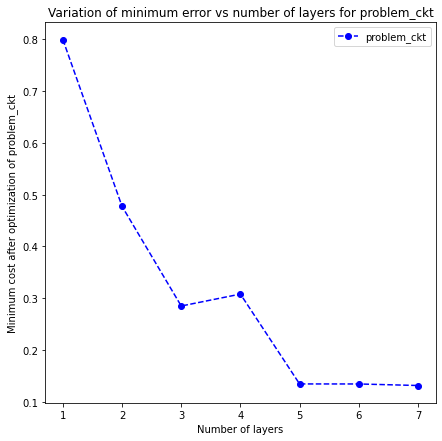

In [13]:
c2.show_plot()

From the above plot, it seems that at least for this chosen circuit ansatz, the circuit with lower number of layers is not able to achieve the target quantum state very well (eg cost is very high for layers = 1). 

The cost initially falls with a large rate as the number of layers increases from 1, indicating that circuits with larger number of layers are able to achieve the random target quantum state much more closely than 1-layered circuit. 

However, once the number of layers has increase up to 6 or 7, the cost does not fall much, which likely means that the expressing power of the circuit has saturated as layers are increased beyond a point.

### Some alternative parametrized circuits

### Alternative 1 - Odd layer with both RX and RZ gates, instead of only RX gates.

Let us hypothesize as follows: perhaps increasing the variety of rotations in the odd layer could improve the cost. To that end, let us try a different ansatz: the first attempt being the odd layer having both RX and RZ gates. The number of parameters (for the same number of layers) will now increase as compared to the previous circuit.

In [14]:
class alternative_ckt_1(parametric_ckt):
    def append_odd_layer(self, sub_layer_id):
        thetax = ParameterVector('thetax'+str(sub_layer_id), length=self.num_qubits)
        thetaz = ParameterVector('thetaz'+str(sub_layer_id), length=self.num_qubits)
        for i in range(self.num_qubits):
            self.qc.rx(thetax[i], i)
            self.qc.rz(thetaz[i], i)

    def append_even_layer(self, sub_layer_id):
        theta = ParameterVector('theta'+str(sub_layer_id), length=self.num_qubits)
        for i in range(self.num_qubits):
            self.qc.rz(theta[i], i)
        for i in range(self.num_qubits):
            for j in range(i+1,self.num_qubits):
                self.qc.cz(i,j) 

As before, let us try to visualize the circuit for 4 qubits and 2 layers:

In [15]:
c3 = alternative_ckt_1(4)
c3.name = 'alternative_ckt_1'
c3.barriers_on = True
c3.build_ckt(2)
qc3 = c3.get_ckt()
qc3.draw(output='text')

-----------------------------------------------------------------
Circuit  alternative_ckt_1  constructed with  2  layers. Number of parameters =  24 .


┌────────────────┐┌────────────────┐ ░ ┌───────────────┐                  »
q_0: ┤ RX(thetax1[0]) ├┤ RZ(thetaz1[0]) ├─░─┤ RZ(theta2[0]) ├─■──■──■──────────»
     ├────────────────┤├────────────────┤ ░ ├───────────────┤ │  │  │          »
q_1: ┤ RX(thetax1[1]) ├┤ RZ(thetaz1[1]) ├─░─┤ RZ(theta2[1]) ├─■──┼──┼──■──■────»
     ├────────────────┤├────────────────┤ ░ ├───────────────┤    │  │  │  │    »
q_2: ┤ RX(thetax1[2]) ├┤ RZ(thetaz1[2]) ├─░─┤ RZ(theta2[2]) ├────■──┼──■──┼──■─»
     ├────────────────┤├────────────────┤ ░ ├───────────────┤       │     │  │ »
q_3: ┤ RX(thetax1[3]) ├┤ RZ(thetaz1[3]) ├─░─┤ RZ(theta2[3]) ├───────■─────■──■─»
     └────────────────┘└────────────────┘ ░ └───────────────┘                  »
«      ░ ┌────────────────┐┌────────────────┐ ░ ┌───────────────┐            »
«q_0: ─░─┤ RX(thetax3[0]) ├┤ RZ(thetaz3[0]) ├─░─┤ RZ(theta4[0]) ├─■──■──■────»
«      ░ ├────────────────┤├────────────────┤ ░ ├───────────────┤ │  │  │    »
«q_1: ─░─┤ RX(thetax3[1]) ├┤ RZ(thetaz3[1]) ├─░─┤ RZ(theta4[1]) ├─■──┼──┼──■─»
«      ░ ├────────────────┤├────────────────┤ ░ ├───────────────┤    │  │  │ »
«q_2: ─░─┤ RX(thetax3[2]) ├┤ RZ(thetaz3[2]) ├─░─┤ RZ(theta4[2]) ├────■──┼──■─»
«      ░ ├────────────────┤├────────────────┤ ░ ├───────────────┤       │    »
«q_3: ─░─┤ RX(thetax3[3]) ├┤ RZ(thetaz3[3]) ├─░─┤ RZ(theta4[3]) ├───────■────»
«      ░ └────────────────┘└────────────────┘ ░ └───────────────┘            »
«            ░ 
«q_0: ───────░─
«            ░ 
«q_1: ─■─────░─
«      │     ░ 
«q_2: ─┼──■──░─
«      │  │  ░ 
«q_3: ─■──■──░─
«            ░

Optimizing these circuits upto maximum layers = 7:

In [16]:
c4 = alternative_ckt_1(4)
c4.name = 'alternative_ckt_1'
c4.max_iter = 300
c4.theta_step = 0.1
c4.alpha = 1
c4.max_layers = 7
c4.run()

-----------------------------------------------------------------------
Initializing the target quantum state of  4  qubit(s) randomly as = 
 [[0.23159775+0.26854207j]
 [0.00311054+0.21447093j]
 [0.29194447+0.13477361j]
 [0.17650717+0.08413362j]
 [0.14187615+0.0357318j ]
 [0.24618063+0.11442822j]
 [0.15077095+0.10407606j]
 [0.03843793+0.10371948j]
 [0.29033053+0.05840304j]
 [0.18982017+0.03884797j]
 [0.28842729+0.01764276j]
 [0.05958415+0.02353189j]
 [0.29649158+0.18139203j]
 [0.20412371+0.00778893j]
 [0.20336406+0.26472618j]
 [0.18037261+0.16232797j]]
Norm of the above vector is  1.0
-----------------------------------------------------------------
Circuit  alternative_ckt_1  constructed with  1  layers. Number of parameters =  12 .
-----------------------------------------------------------------
Initialized circuit parameters prior to gradient descent randomly as follows: 
idx =  thetaz1[0] params =  0.03719052023213644
idx =  thetaz1[3] params =  0.04312312828020062
idx =  thetax1[

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  36  | cost =  0.7991003304960883
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  37  | cost =  0.799110631940232
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  38  | cost =  0.7991254391927309
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  39  | cost =  0.7991428397477945
----------------------------------------------------------------------
REDUCING ALPHA TO  0.31622776601683794  at iteration =  40
---------------------------------------------------------------------------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  78  | cost =  0.799323495981413
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  79  | cost =  0.7993258904942113
----------------------------------------------------------------------
REDUCING ALPHA TO  0.09999999999999999  at iteration =  80
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  80  | cost =  0.7993282057951647
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  81  | cost =  0.7993289119945416
---------------------------------------------------------------------------

----------------------------------------------------------------------
REDUCING ALPHA TO  0.03162277660168379  at iteration =  120
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  120  | cost =  0.7993512775679246
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  121  | cost =  0.7993514219873804
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  122  | cost =  0.7993515659004305
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  123  | cost =  0.7993517093086973
---------------------------------------------------------------------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  162  | cost =  0.7993569253333758
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  163  | cost =  0.7993570498337383
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  164  | cost =  0.7993571738923528
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  165  | cost =  0.7993572975106745
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  166  | cost =  0.7993574206901547


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  203  | cost =  0.7993616827371818
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  204  | cost =  0.7993617902781799
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  205  | cost =  0.7993618974339549
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  206  | cost =  0.7993620042058058
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  207  | cost =  0.7993621105950288


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  245  | cost =  0.7993658822882084
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  246  | cost =  0.7993659747266039
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  247  | cost =  0.7993660668312165
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  248  | cost =  0.7993661586031943
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  249  | cost =  0.7993662500436818


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  287  | cost =  0.7993694901111282
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  288  | cost =  0.7993695694800479
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  289  | cost =  0.7993696485604918
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  290  | cost =  0.7993697273534677
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  1  | At end of iteration =  291  | cost =  0.7993698058599806


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  15  | cost =  0.774127630927393
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  16  | cost =  0.7629241039006666
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  17  | cost =  0.7541857198504652
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  18  | cost =  0.7472693560346849
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  19  | cost =  0.7416922221593165
------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  56  | cost =  0.645327898667055
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  57  | cost =  0.6414053778130467
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  58  | cost =  0.6372281387156521
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  59  | cost =  0.6327864036069295
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  60  | cost =  0.628072459965972
-------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  97  | cost =  0.48576300339463724
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  98  | cost =  0.48489351889148197
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  99  | cost =  0.4840529406454259
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  100  | cost =  0.48324054364549923
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  101  | cost =  0.4824555938698258


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  138  | cost =  0.4697640097367564
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  139  | cost =  0.46966265372733307
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  140  | cost =  0.4695623474792871
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  141  | cost =  0.4694630766483945
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  142  | cost =  0.4693648270434795

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  179  | cost =  0.4663311456209771
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  180  | cost =  0.4662626085724737
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  181  | cost =  0.4661946489542629
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  182  | cost =  0.46612725792334536
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  183  | cost =  0.4660604267486211

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  220  | cost =  0.46391084919893155
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  221  | cost =  0.46385981595878806
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  222  | cost =  0.46380907760654116
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  223  | cost =  0.46375862899843123
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  224  | cost =  0.4637084650598

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  261  | cost =  0.46201182527925644
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  262  | cost =  0.4619693165642204
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  263  | cost =  0.4619269397810486
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  264  | cost =  0.46188469197145693
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  2  | At end of iteration =  265  | cost =  0.461842570216213

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  1  | cost =  1.2230009842925835
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  2  | cost =  1.1972866012185943
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  3  | cost =  1.1679430697262845
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  4  | cost =  1.1287367484713848
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  5  | cost =  1.0746026887172873
----------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  42  | cost =  0.5341473408713683
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  43  | cost =  0.5024494675803993
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  44  | cost =  0.48632463717049784
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  45  | cost =  0.46203878013784855
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  46  | cost =  0.4497275750112289
---

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  83  | cost =  0.32423612548272923
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  84  | cost =  0.3237835154747115
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  85  | cost =  0.3210464707119436
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  86  | cost =  0.31940395425971774
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  87  | cost =  0.31760935474698315
--

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  124  | cost =  0.2967877582232771
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  125  | cost =  0.2967268588724312
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  126  | cost =  0.2966667410290382
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  127  | cost =  0.2966073864739578
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  128  | cost =  0.2965487774222959


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  165  | cost =  0.29477241953429506
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  166  | cost =  0.2947321316822802
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  167  | cost =  0.2946921290887314
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  168  | cost =  0.29465240438404866
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  169  | cost =  0.294612950361383

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  206  | cost =  0.2932902297889833
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  207  | cost =  0.2932570370673137
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  208  | cost =  0.2932239313290504
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  209  | cost =  0.29319090974616635
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  210  | cost =  0.2931579695599755

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  247  | cost =  0.2919765596678114
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  248  | cost =  0.2919452256658592
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  249  | cost =  0.29191390661252203
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  250  | cost =  0.29188260158856144
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  251  | cost =  0.291851309703057

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  288  | cost =  0.2906967672173867
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  289  | cost =  0.2906655382833896
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  290  | cost =  0.2906343041720817
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  291  | cost =  0.2906030647178084
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  3  | At end of iteration =  292  | cost =  0.2905718197654223


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  5  | cost =  1.060922251312397
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  6  | cost =  0.9825066766382018
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  7  | cost =  0.9102601951053193
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  8  | cost =  0.8563247292644135
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  9  | cost =  0.8084775297627412
-----------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  46  | cost =  0.49532559789638514
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  47  | cost =  0.48630433949899166
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  48  | cost =  0.47760311146484213
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  49  | cost =  0.4692922479835661
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  50  | cost =  0.46131009958664143
-

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  87  | cost =  0.3469616990728165
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  88  | cost =  0.3459339697318966
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  89  | cost =  0.34494044192013257
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  90  | cost =  0.3439717564432099
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  91  | cost =  0.34302160236977564
---

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  128  | cost =  0.31764154085402446
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  129  | cost =  0.3174342658888937
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  130  | cost =  0.3172279758827849
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  131  | cost =  0.317022669534813
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  132  | cost =  0.31681834539837417

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  169  | cost =  0.30992720622947084
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  170  | cost =  0.3097582704828911
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  171  | cost =  0.30959019775331115
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  172  | cost =  0.30942298385530737
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  173  | cost =  0.30925662456490

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  210  | cost =  0.30366069921494665
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  211  | cost =  0.3035233968519678
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  212  | cost =  0.30338676364427136
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  213  | cost =  0.30325079449537656
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  214  | cost =  0.30311548429903

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  251  | cost =  0.2985249433306032
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  252  | cost =  0.2984108258669916
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  253  | cost =  0.29829716386498645
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  254  | cost =  0.298183952058313
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  255  | cost =  0.29807118518063586

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  292  | cost =  0.2941635549064845
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  293  | cost =  0.294063804905028
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  294  | cost =  0.2939642957003286
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  295  | cost =  0.29386502212241267
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  4  | At end of iteration =  296  | cost =  0.2937659790061486


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  3  | cost =  1.1554857239490075
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  4  | cost =  1.1121301926633533
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  5  | cost =  1.0456093997017935
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  6  | cost =  0.9452391955177296
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  7  | cost =  0.8482414159074118
----------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  44  | cost =  0.5100124052583921
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  45  | cost =  0.49007947329436996
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  46  | cost =  0.4697289555068598
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  47  | cost =  0.45268978443852614
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  48  | cost =  0.433972344534106
----

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  85  | cost =  0.3188983558660093
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  86  | cost =  0.3181162970547283
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  87  | cost =  0.31733909237377406
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  88  | cost =  0.31664847227748716
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  89  | cost =  0.3159789855716472
---

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  126  | cost =  0.29678627391315165
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  127  | cost =  0.2965958621883582
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  128  | cost =  0.2964046311887378
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  129  | cost =  0.29621256105288857
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  130  | cost =  0.296019632100996

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  167  | cost =  0.28810264800083085
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  168  | cost =  0.2878629957423963
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  169  | cost =  0.28762175273074836
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  170  | cost =  0.2873789010309562
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  171  | cost =  0.287134422771604

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  208  | cost =  0.27679067481608616
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  209  | cost =  0.276472191133272
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  210  | cost =  0.27615148098758024
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  211  | cost =  0.27582853314835426
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  212  | cost =  0.275503336697914

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  249  | cost =  0.26182657752134486
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  250  | cost =  0.26141195526257865
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  251  | cost =  0.2609950114914256
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  252  | cost =  0.26057575629835217
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  253  | cost =  0.26015420051194

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  290  | cost =  0.24311068565120536
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  291  | cost =  0.24261762780374044
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  292  | cost =  0.24212331996652559
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  293  | cost =  0.24162780498639783
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  5  | At end of iteration =  294  | cost =  0.2411311263992

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  1  | cost =  1.2085930368146889
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  2  | cost =  1.1796831434919453
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  3  | cost =  1.147350739699084
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  4  | cost =  1.1055931158173542
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  5  | cost =  1.0475254774262006
-----------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  42  | cost =  0.5310045083118463
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  43  | cost =  0.5151304662391708
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  44  | cost =  0.5027510145060142
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  45  | cost =  0.4930027029566573
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  46  | cost =  0.4829960648534531
-----

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  83  | cost =  0.3061507087733612
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  84  | cost =  0.303504957799896
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  85  | cost =  0.3005885921110022
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  86  | cost =  0.29818567770113014
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  87  | cost =  0.29588695411999255
----

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  124  | cost =  0.23960861539067643
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  125  | cost =  0.23916474199886184
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  126  | cost =  0.23872260278441093
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  127  | cost =  0.23828222099021967
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  128  | cost =  0.2378436214916

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  165  | cost =  0.2229712638884735
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  166  | cost =  0.22260489193359986
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  167  | cost =  0.22224014823889737
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  168  | cost =  0.22187700191038895
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  169  | cost =  0.22151542120888

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  206  | cost =  0.20891526024925386
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  207  | cost =  0.20858741450565785
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  208  | cost =  0.2082598809787024
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  209  | cost =  0.20793264293498845
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  210  | cost =  0.20760568505340

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  247  | cost =  0.19570284959753018
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  248  | cost =  0.19538988842924335
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  249  | cost =  0.19507772555684627
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  250  | cost =  0.1947663951078274
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  251  | cost =  0.19445593151755

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  288  | cost =  0.18387330423610374
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  289  | cost =  0.18361814735837248
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  290  | cost =  0.18336483474879736
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  291  | cost =  0.18311337326781532
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  6  | At end of iteration =  292  | cost =  0.1828637688290

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  1  | cost =  1.2047303081920244
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  2  | cost =  1.1687751399957107
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  3  | cost =  1.124176482375683
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  4  | cost =  1.0607857974842272
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  5  | cost =  0.9755990581726713
-----------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  42  | cost =  0.5435624682270493
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  43  | cost =  0.5235552607620114
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  44  | cost =  0.5068171170325289
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  45  | cost =  0.4915142896520002
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  46  | cost =  0.47622960587865626
----

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  83  | cost =  0.30696655680277013
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  84  | cost =  0.3035488381786495
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  85  | cost =  0.3002469969687321
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  86  | cost =  0.2975765922543028
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  87  | cost =  0.295116847413088
-----

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  124  | cost =  0.23526050943880616
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  125  | cost =  0.2346814095540975
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  126  | cost =  0.2341000511380917
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  127  | cost =  0.23351639481422623
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  128  | cost =  0.232930402509039

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  165  | cost =  0.20924473941383606
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  166  | cost =  0.208540527933154
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  167  | cost =  0.2078324539957281
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  168  | cost =  0.20712048640564443
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  169  | cost =  0.2064045952428693

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  206  | cost =  0.1771030581533334
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  207  | cost =  0.17624296755819113
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  208  | cost =  0.17538041728921264
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  209  | cost =  0.17451556774858315
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  210  | cost =  0.17364858865926

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  247  | cost =  0.14256753360131616
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  248  | cost =  0.14184607464445273
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  249  | cost =  0.14113659542934104
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  250  | cost =  0.14043955226887045
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  251  | cost =  0.1397553943125

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  288  | cost =  0.12602656935254888
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  289  | cost =  0.1259789695674607
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  290  | cost =  0.12594584473743325
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  291  | cost =  0.12592681814902448
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_1 | Layers =  7  | At end of iteration =  292  | cost =  0.12592150509319

Let us see the variation of minimum cost with the number of layers this time:

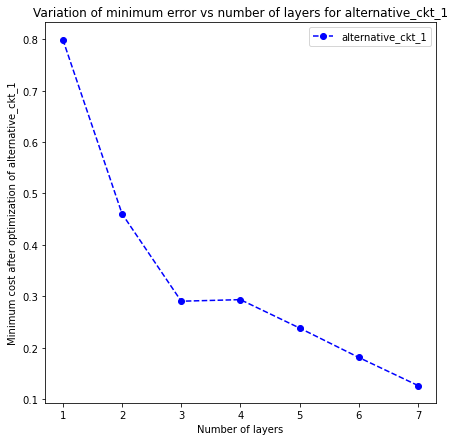

In [17]:
c4.show_plot()

A similar behaviour can be seen: as the number of layers increases, the circuit is able to simulate the random target quantum state more closely than before, but once the number of layers increases to a point, the reduction in cost seems to saturate.

Towards the end of the notebook, a comparative plot of these minimum costs will be constructed for the different types of ansatze considered.

### Alternative 2 - Odd layer with general U3 gates

As a final attempt, let us construct the odd layer with U3 gates for which three parameters (rotation angles) can be specified.

In [18]:
class alternative_ckt_2(parametric_ckt):
    def append_odd_layer(self, sub_layer_id):
        theta = ParameterVector('theta'+str(sub_layer_id), length=self.num_qubits)
        phi = ParameterVector('phi'+str(sub_layer_id), length=self.num_qubits)
        lmbda = ParameterVector('lmbda'+str(sub_layer_id), length=self.num_qubits)
        for i in range(self.num_qubits):
            self.qc.u3(theta[i], phi[i], lmbda[i], i)

    def append_even_layer(self, sub_layer_id):
        theta = ParameterVector('theta'+str(sub_layer_id), length=self.num_qubits)
        for i in range(self.num_qubits):
            self.qc.rz(theta[i], i)
        for i in range(self.num_qubits):
            for j in range(i+1,self.num_qubits):
                self.qc.cz(i,j) 

Visualizing the circuit for 2 layers gives:

In [19]:
c5 = alternative_ckt_2(4)
c5.barriers_on = True
c5.build_ckt(2)
qc5 = c5.get_ckt()
qc5.draw(output='text')

-----------------------------------------------------------------
Circuit  Circuit  constructed with  2  layers. Number of parameters =  32 .


┌─────────────────────────────────┐ ░ ┌───────────────┐                  »
q_0: ┤ U3(theta1[0],phi1[0],lmbda1[0]) ├─░─┤ RZ(theta2[0]) ├─■──■──■──────────»
     ├─────────────────────────────────┤ ░ ├───────────────┤ │  │  │          »
q_1: ┤ U3(theta1[1],phi1[1],lmbda1[1]) ├─░─┤ RZ(theta2[1]) ├─■──┼──┼──■──■────»
     ├─────────────────────────────────┤ ░ ├───────────────┤    │  │  │  │    »
q_2: ┤ U3(theta1[2],phi1[2],lmbda1[2]) ├─░─┤ RZ(theta2[2]) ├────■──┼──■──┼──■─»
     ├─────────────────────────────────┤ ░ ├───────────────┤       │     │  │ »
q_3: ┤ U3(theta1[3],phi1[3],lmbda1[3]) ├─░─┤ RZ(theta2[3]) ├───────■─────■──■─»
     └─────────────────────────────────┘ ░ └───────────────┘                  »
«      ░ ┌─────────────────────────────────┐ ░ ┌───────────────┐               »
«q_0: ─░─┤ U3(theta3[0],phi3[0],lmbda3[0]) ├─░─┤ RZ(theta4[0]) ├─■──■──■───────»
«      ░ ├─────────────────────────────────┤ ░ ├───────────────┤ │  │  │       »
«q_1: ─░─┤ U3(theta3[1],phi3[1],lmbda3[1]) ├─░─┤ RZ(theta4[1]) ├─■──┼──┼──■──■─»
«      ░ ├─────────────────────────────────┤ ░ ├───────────────┤    │  │  │  │ »
«q_2: ─░─┤ U3(theta3[2],phi3[2],lmbda3[2]) ├─░─┤ RZ(theta4[2]) ├────■──┼──■──┼─»
«      ░ ├─────────────────────────────────┤ ░ ├───────────────┤       │     │ »
«q_3: ─░─┤ U3(theta3[3],phi3[3],lmbda3[3]) ├─░─┤ RZ(theta4[3]) ├───────■─────■─»
«      ░ └─────────────────────────────────┘ ░ └───────────────┘               »
«         ░ 
«q_0: ────░─
«         ░ 
«q_1: ────░─
«         ░ 
«q_2: ─■──░─
«      │  ░ 
«q_3: ─■──░─
«         ░

Let us run the optimization routine as before:

In [20]:
c6 = alternative_ckt_2(4)
c6.name = 'alternative_ckt_2'
c6.max_iter = 300
c6.theta_step = 0.1
c6.alpha = 1
c6.max_layers = 7
c6.run()

-----------------------------------------------------------------------
Initializing the target quantum state of  4  qubit(s) randomly as = 
 [[0.23159775+0.26854207j]
 [0.00311054+0.21447093j]
 [0.29194447+0.13477361j]
 [0.17650717+0.08413362j]
 [0.14187615+0.0357318j ]
 [0.24618063+0.11442822j]
 [0.15077095+0.10407606j]
 [0.03843793+0.10371948j]
 [0.29033053+0.05840304j]
 [0.18982017+0.03884797j]
 [0.28842729+0.01764276j]
 [0.05958415+0.02353189j]
 [0.29649158+0.18139203j]
 [0.20412371+0.00778893j]
 [0.20336406+0.26472618j]
 [0.18037261+0.16232797j]]
Norm of the above vector is  1.0
-----------------------------------------------------------------
Circuit  alternative_ckt_2  constructed with  1  layers. Number of parameters =  16 .
-----------------------------------------------------------------
Initialized circuit parameters prior to gradient descent randomly as follows: 
idx =  phi1[2] params =  0.03719052023213644
idx =  theta2[0] params =  0.04312312828020062
idx =  theta1[3] pa

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  35  | cost =  0.8158031934806509
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  36  | cost =  0.8113398410236305
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  37  | cost =  0.8082306793358158
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  38  | cost =  0.8060752383661716
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  39  | cost =  0.8045774440204324
-----

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  76  | cost =  0.8006583537551719
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  77  | cost =  0.8006393221314774
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  78  | cost =  0.8006211364699763
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  79  | cost =  0.8006037456651776
----------------------------------------------------------------------
REDUCING ALPHA TO  0.09999999999999999  at iteration =  80
--------------------------------------------------------------------------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  117  | cost =  0.8004372329082734
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  118  | cost =  0.8004340617648426
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  119  | cost =  0.8004309283985394
----------------------------------------------------------------------
REDUCING ALPHA TO  0.03162277660168379  at iteration =  120
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  120  | cost =  0.8004278322836165
---------------------------------------------------------------------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  158  | cost =  0.8003934677652118
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  159  | cost =  0.8003926272695367
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  160  | cost =  0.8003917898671822
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  161  | cost =  0.8003909555453854
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  162  | cost =  0.8003901242914534


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  199  | cost =  0.8003614145366625
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  200  | cost =  0.8003606910881997
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  201  | cost =  0.8003599702612796
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  202  | cost =  0.8003592520455878
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  203  | cost =  0.8003585364308606


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  240  | cost =  0.8003337977775942
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  241  | cost =  0.8003331738646473
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  242  | cost =  0.8003325521886856
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  243  | cost =  0.8003319327412248
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  244  | cost =  0.800331315513819
-

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  281  | cost =  0.8003099649683615
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  282  | cost =  0.8003094262030805
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  283  | cost =  0.8003088893561876
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  284  | cost =  0.8003083544206012
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  1  | At end of iteration =  285  | cost =  0.8003078213892704


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  6  | cost =  0.9384476879387106
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  7  | cost =  0.8554442249526376
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  8  | cost =  0.758425289394707
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  9  | cost =  0.6590088184497527
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  10  | cost =  0.5722355551366668
----------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  47  | cost =  0.5704249298543478
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  48  | cost =  0.5606303384209055
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  49  | cost =  0.5513038991150756
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  50  | cost =  0.5424547573432104
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  51  | cost =  0.5340919819259388
-----

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  88  | cost =  0.4457387630104784
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  89  | cost =  0.44555392226902185
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  90  | cost =  0.4453730946057314
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  91  | cost =  0.44519611374239243
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  92  | cost =  0.4450228237168941
---

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  129  | cost =  0.44093323471612894
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  130  | cost =  0.44090026784341974
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  131  | cost =  0.4408674290844028
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  132  | cost =  0.44083471745331276
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  133  | cost =  0.44080213197604

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  170  | cost =  0.4396773018135412
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  171  | cost =  0.4396488992367987
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  172  | cost =  0.43962059323746683
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  173  | cost =  0.43959238323812827
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  174  | cost =  0.439564268668794

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  211  | cost =  0.43858651491419626
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  212  | cost =  0.4385616681874191
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  213  | cost =  0.43853689947775965
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  214  | cost =  0.4385122084403356
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  215  | cost =  0.438487594734390

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  252  | cost =  0.43762847254699005
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  253  | cost =  0.4376065801224857
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  254  | cost =  0.4375847543858888
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  255  | cost =  0.4375629951193106
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  256  | cost =  0.4375413021070564

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  293  | cost =  0.4367834422571121
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  294  | cost =  0.4367641255097408
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  295  | cost =  0.436744867983324
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  296  | cost =  0.4367256695254732
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  2  | At end of iteration =  297  | cost =  0.4367065299848785
-

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  11  | cost =  1.3457334342913414
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  12  | cost =  0.5816181065618307
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  13  | cost =  0.9453480574890142
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  14  | cost =  1.3656700273250126
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  15  | cost =  0.8626757176873858
-----

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  52  | cost =  0.46751687616330734
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  53  | cost =  0.4578677825251424
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  54  | cost =  0.4488803121079736
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  55  | cost =  0.4404429570093147
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  56  | cost =  0.43261052013640966
---

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  93  | cost =  0.34698874425279863
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  94  | cost =  0.34469497789165127
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  95  | cost =  0.34249896433162286
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  96  | cost =  0.340390521821838
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  97  | cost =  0.3383607409568541
---

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  134  | cost =  0.29754417887643503
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  135  | cost =  0.2971587490800167
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  136  | cost =  0.2967742896923186
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  137  | cost =  0.29639078379602823
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  138  | cost =  0.296008214749658

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  175  | cost =  0.2823813166573988
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  176  | cost =  0.2820242764894249
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  177  | cost =  0.2816676926249725
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  178  | cost =  0.2813115560953923
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  179  | cost =  0.2809558580548728


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  216  | cost =  0.26803110251747553
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  217  | cost =  0.26768637804536277
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  218  | cost =  0.2673418062859342
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  219  | cost =  0.26699738051607064
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  220  | cost =  0.26665309400220

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  257  | cost =  0.25394875810971257
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  258  | cost =  0.2536045376431703
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  259  | cost =  0.2532601752016773
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  260  | cost =  0.2529156633129297
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  261  | cost =  0.2525709945315246

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  298  | cost =  0.23964758489581578
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  299  | cost =  0.23929244527987228
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  3  | At end of iteration =  300  | cost =  0.23893696338547912
----------------------------------------------------------------------
Optimization complete.
After optimization, the optimal parameters are 
 {Parameter(lmbda3[0]): 0.18456275435040778, Parameter(phi1[1]): -0.3756637123014897, Parameter(phi5[3]): -0.12275728795321125, Parameter(theta2[0]): 0.18181248829997346, Parameter(theta2[1]): -0.3719056999350267, Parameter(phi5[0]): -0.12037720520751055,

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  9  | cost =  1.3004879070000577
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  10  | cost =  1.0326226496690463
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  11  | cost =  0.7836494864573417
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  12  | cost =  0.7278071718715339
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  13  | cost =  1.2761587306115607
------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  50  | cost =  0.6769244214471097
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  51  | cost =  0.5201805647315297
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  52  | cost =  0.6963472811124811
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  53  | cost =  0.49369983334252365
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  54  | cost =  0.7003072025966975
----

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  91  | cost =  0.2133954680741733
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  92  | cost =  0.23860657669643243
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  93  | cost =  0.21256104115994462
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  94  | cost =  0.25542701022083103
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  95  | cost =  0.21839938678303306
-

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  132  | cost =  0.17825351150367466
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  133  | cost =  0.1779346278232281
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  134  | cost =  0.17762534502819177
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  135  | cost =  0.17732479065007845
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  136  | cost =  0.17703219853225

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  173  | cost =  0.168797571519951
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  174  | cost =  0.1686094563722813
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  175  | cost =  0.16842226906590188
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  176  | cost =  0.16823597148643135
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  177  | cost =  0.1680505267169953

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  214  | cost =  0.16152865133670175
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  215  | cost =  0.16135618243468217
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  216  | cost =  0.1611837044553088
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  217  | cost =  0.16101120648196637
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  218  | cost =  0.16083867807726

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  255  | cost =  0.15437958075853675
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  256  | cost =  0.15420255125094431
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  257  | cost =  0.15402542170053435
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  258  | cost =  0.1538481980191168
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  259  | cost =  0.15367088645074

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  296  | cost =  0.1471322340759907
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  297  | cost =  0.14695896855413512
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  298  | cost =  0.14678606037351405
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  299  | cost =  0.14661352435008998
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  4  | At end of iteration =  300  | cost =  0.14644137536666

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  1  | cost =  1.0676537893040234
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  2  | cost =  0.9378250941593798
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  3  | cost =  0.7461388340217587
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  4  | cost =  0.553079010863847
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  5  | cost =  0.5281493351390275
-----------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  42  | cost =  0.5730887988558778
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  43  | cost =  0.5443144756246847
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  44  | cost =  0.5217559379372039
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  45  | cost =  0.5027895032257228
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  46  | cost =  0.4859866642102096
-----

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  83  | cost =  0.32801099256765726
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  84  | cost =  0.32227020636593795
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  85  | cost =  0.31667629078483356
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  86  | cost =  0.3127082658349234
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  87  | cost =  0.30920155930846677
-

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  124  | cost =  0.2598015711220158
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  125  | cost =  0.2594670302448042
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  126  | cost =  0.2591326165393424
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  127  | cost =  0.2587982982235984
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  128  | cost =  0.2584640427144953


------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  165  | cost =  0.24585760023414094
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  166  | cost =  0.24550344399959645
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  167  | cost =  0.24514825697664208
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  168  | cost =  0.2447920184714561
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  169  | cost =  0.24443470830326

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  206  | cost =  0.23033543491598568
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  207  | cost =  0.22992919137397028
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  208  | cost =  0.22952167011902874
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  209  | cost =  0.22911288572969177
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  210  | cost =  0.2287028539965

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  247  | cost =  0.2129097902723592
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  248  | cost =  0.21247575851841521
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  249  | cost =  0.2120419676423273
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  250  | cost =  0.2116084704143862
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  251  | cost =  0.2111753196364807

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  288  | cost =  0.1958241489208291
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  289  | cost =  0.19543648254627674
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  290  | cost =  0.19505052512450907
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  291  | cost =  0.19466628026670077
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  5  | At end of iteration =  292  | cost =  0.19428374979156

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  1  | cost =  1.054615305062848
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  2  | cost =  0.8942497371421924
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  3  | cost =  0.6577641650417014
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  4  | cost =  0.5014553399390104
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  5  | cost =  1.4549508234827286
-----------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  42  | cost =  0.5839278714890231
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  43  | cost =  0.5521026506019758
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  44  | cost =  0.5233378981433118
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  45  | cost =  0.49561874358096963
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  46  | cost =  0.46837624017751306
---

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  83  | cost =  0.2081680195629083
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  84  | cost =  0.24815313748016804
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  85  | cost =  0.21005812980066732
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  86  | cost =  0.27340645062879926
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  87  | cost =  0.21640258834436288
-

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  124  | cost =  0.15320465002095904
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  125  | cost =  0.1525580662563934
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  126  | cost =  0.15201814210480422
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  127  | cost =  0.15151956967768282
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  128  | cost =  0.15105829790180

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  165  | cost =  0.14079329125055062
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  166  | cost =  0.14059021032557825
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  167  | cost =  0.1403897570790242
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  168  | cost =  0.14019188954745482
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  169  | cost =  0.13999656665028

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  206  | cost =  0.13425660877048626
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  207  | cost =  0.1341352632725032
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  208  | cost =  0.13401543711996056
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  209  | cost =  0.13389711519599395
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  210  | cost =  0.13378028275355

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  247  | cost =  0.1303958669124965
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  248  | cost =  0.130327345061217
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  249  | cost =  0.13025992369392922
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  250  | cost =  0.1301935955384378
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  251  | cost =  0.13012835337624234

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  288  | cost =  0.12841362791202607
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  289  | cost =  0.12838441697507708
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  290  | cost =  0.12835600952445012
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  291  | cost =  0.12832839730513473
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  6  | At end of iteration =  292  | cost =  0.1283015719625

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  1  | cost =  1.0243202654549344
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  2  | cost =  0.8127214673815868
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  3  | cost =  0.5451496542080907
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  4  | cost =  1.239172426060389
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  5  | cost =  1.3766292095411101
-----------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  42  | cost =  0.6980580970811054
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  43  | cost =  0.64286331308642
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  44  | cost =  0.7132324289646842
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  45  | cost =  0.6194825593357894
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  46  | cost =  0.7170207929833071
-------

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  83  | cost =  0.2547466257183683
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  84  | cost =  0.25747810103871405
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  85  | cost =  0.23506697580742197
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  86  | cost =  0.24500451934585932
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  87  | cost =  0.222136021665064
---

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  124  | cost =  0.15773004073855315
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  125  | cost =  0.15669942574916332
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  126  | cost =  0.15591858202290318
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  127  | cost =  0.15514258176651513
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  128  | cost =  0.1544139745658

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  165  | cost =  0.13640453010043205
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  166  | cost =  0.13614489982216232
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  167  | cost =  0.13590242476770983
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  168  | cost =  0.13567754055115344
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  169  | cost =  0.1354706572382

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  206  | cost =  0.14049645704645983
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  207  | cost =  0.14088347394635747
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  208  | cost =  0.1412762965284843
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  209  | cost =  0.14167437067154257
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  210  | cost =  0.14207716034600

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  247  | cost =  0.15713005755648468
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  248  | cost =  0.15749524241827492
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  249  | cost =  0.15785737910185724
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  250  | cost =  0.15821647856766244
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  251  | cost =  0.1585725558620

------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  288  | cost =  0.1699341959978769
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  289  | cost =  0.17020140572022305
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  290  | cost =  0.17046689050542807
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  291  | cost =  0.17073066348531998
------------------------------------------------------------------------------------------------
Circuit =  alternative_ckt_2 | Layers =  7  | At end of iteration =  292  | cost =  0.17099273585753

Plotting the cost vs number of layers gives a similar plot:

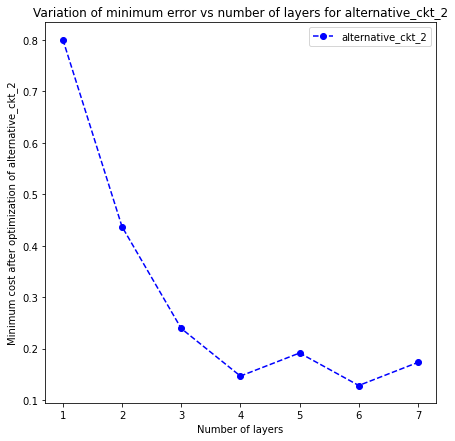

In [21]:
c6.show_plot()

### A comparison
Plotting the results for all three types of circuits on the same scale gives the following:

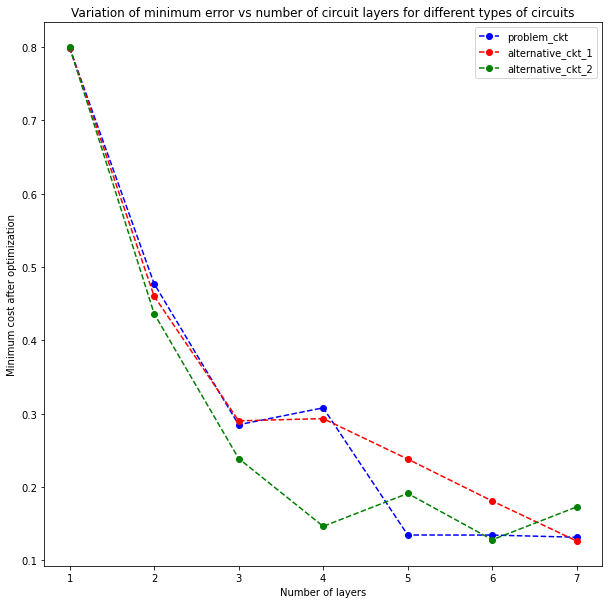

In [22]:
xa1 = c2.layer_arr
ya1 = c2.cost_arr
plt.figure(figsize=(10,10))
plt.plot(xa1,ya1,'--bo', label='problem_ckt')
ya2 = c4.cost_arr
plt.plot(xa1, ya2, '--ro', label='alternative_ckt_1')
ya3 = c6.cost_arr
plt.plot(xa1, ya3, '--go', label='alternative_ckt_2')
plt.legend()
plt.xlabel("Number of layers")
plt.ylabel("Minimum cost after optimization")
plt.title("Variation of minimum error vs number of circuit layers for different types of circuits")
plt.show()

From this graph, it seems that the following can be concluded:

* For all three types of circuits considered here, the reduction and then saturation of the error while simulating a random quantum state seems to be a general trend.

* For the three and four layer cases, out of the three types of circuits, alternative_ckt_2 (the one with U3 gates) seems to give a lower error than the other two.

### Conclusion

* The minimum error while simulating a random quantum state from a variational circuit (of such a type) initially reduces sharply, and then the rate of reduction slows down, as the number of layers is increased. This reduction and then saturation of the error while simulating a random quantum state seems to be a general trend, at least for this class of circuits which have layers of alternating rotation and entanglement blocks.

* The circuit which uses U3 gates (alternative_ckt_2) gives lower error than the other 2 types of circuits when the number of layers is three and four. Therefore, it is possible that some types of circuit choices can approximate the arbitrary quantum state much more closely than others. In applications where circuit depth is a constraint, such circuits might be useful.

* The learning rate is an important parameter which can impact the optimization process.

### Scope for further exploration

* Different types of entanglement mapping in the even layer could be explored and may lead to circuits which can simulate the target state well even with less number of layers than the ones studied here.

* The behaviour of minimum error can be studied for even higher number of layers.

* Optimization techiques with adaptive learning rates could be tried.